# Technical note: Sensitivities of a logistic model

In this note we look at a logistic model, defined with initial conditions that depend on model parameters.

## The model

State:
\begin{align}
\frac{dy}{dt} = h y (1 - y)
\end{align}

Initial condition:
\begin{align}
y(t_0, K, h) = \left[1 + \exp(-h(t_0 + K \log 10)) \right]^{-1}
\end{align}

### Case 1: Time starts at 0

In the first case we use
\begin{align}
K &= -4 \\
h &= 1
\end{align}
and set $t_0 = 0$ to get
\begin{align}
y_0(K, h) = \left[1 + \exp(-h K \log 10) \right]^{-1}
\end{align}

We run for 20 time units.

### Case 2: A negative starting time

The second case is based on a drug-modelling example, and uses a negative starting time!

\begin{align}
K &= -4 \\
h &= 1
\end{align}

Now t_0 = -4.605170185988091 and we will run the simulation for $5.1 - t_0$ time units.

## Case 1

Using the syntax defined from Myokit 1.34.0 onwards, we can write:

In [42]:
import myokit

model = myokit.parse_model(
'''
[[model]]
c.y = 1 / (1 + exp(-c.h * c.K * log(10)))

[engine]
time = 0 bind time

[c]
h = 1
K = -4
dot(y) = h * y * (1 - y)
''')

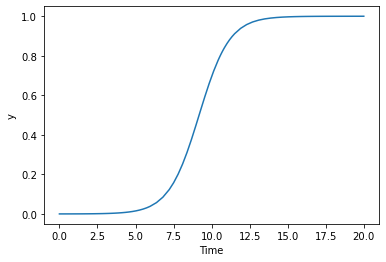

In [43]:
s = myokit.Simulation(model)
d = s.run(20)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('Time')
ax.set_ylabel('y')
ax.plot(d.time(), d['c.y'])
plt.show()

### Proposed API

At the moment, we can't do this:

In [38]:
s = myokit.Simulation(model, sensitivities=(['c.y'], ['c.h', 'c.K']))

NotImplementedError: Sensitivities with respect to parameters used in initial conditions is not implemented (1 / (1 + exp(-c.h * c.K * log(10))) depends on c.h).

The reason for this error is that the simulation stores its _state_ and _default state_ as lists of floating point numbers, so no room for fancy expressions!

## Requirements

- The new API should be backwards compatible wherever possible. Users who do not use the new functionality should not have to change their scripts.
- The existing system with a `state`, `default_state` and `reset()`+`pre()` is already slightly confusing to new users. The new system should not be significantly more confusing.
- A good rule of thumb might be that if users aren't thinking about initial conditions they won't notice any changes

## Decisions

- The methods `sim.state()` and `sim.set_state()` work with floats
- Using `pre()` updates the `default_state` and `default_s_state`, all connection with constants is lost

## Questions 

- Should links to expressions be maintained? These would all have to be stored python-only. From the point of view of the C code there is no such thing as a dependency of the sensitivity state on the constants - this is implemented purely by particular values in the state-sensitivity matrix
- Should set_constant(p) where a model's initial state depends on p affect the default s_state ?
- Should calling set_default_state with expressions be allowed. And if so, should this update the default_s_state? (because setting `x0 = p` implies `dx0/dp = 1`)
  - **Should some link between the `default_state` and the `default_s_state` be maintained?

## Proposal 1A: default_s_state as floats

**The simulation turns the initial state into floats, but maintains model constants in symbolic form**

- When a simulation is created, the `default_s_state` is set based on the model's initial state, i.e. mostly zeroes, except where dx0/dp is non-zero in which case we evaluate this expression.
- Calling `set_state` sets the state (to floats), calling `set_default_state` sets the default state (to floats). Same for `s_state` and `default_s_state`.
- Calling `set_constant` affects constants, but this is interpreted as "during simulations", so does not affect initial state sensitivities.
- Calling `reset()` resets to the default state and `s_state`, which are floats and so not affected by the values of any constants.


## Proposal 1B

- **Option**: We could make `set_default_state` - when called with expressions - also re-evaluate `default_s_state` to spare the user the effort of evaluating dx0/dp? This would mean you could do `sim.set_constant(p, 3)`, `sim.set_default_state(model.initial_values())`, `sim.reset()` as quite a roundabout way to re-evaluate the initial sensitivities.

## Proposal 2: default_s_state as expressions

**The simulation maintains an initial_state in symbolic form, and calling reset() re-evaluates it**

- When a simulation is created, the `default_s_state` is set based on the model's initial state. The `s_state` is set to an evaluation of that state`.
- Calling `set_constant` will affect constants for the rest of the simulation, but will not affect the `s_state`.
- Calling `reset` re-evaluates the `default_state` and also the `default_s_state` if this is a list of expressions.
  - If the user has manually changed the `default_s_state` to remove links to constants, then the `default_s_state` remains unchanged, even though the `default_state` implies certain connections.
- Calling `set_default_state` does not affect the `default_s_state`, because the user may have changed that manually and we don't want to overwrite it?



## Use-cases: Parameter estimation

Below is a series of use cases, all based on parameter estimation, in which we would like to use sensitivities but also re-use the same simulation object with `set_constant` to change parameter values.

### Use case 1: Partially known, partially inferred initial conditions

We have a model where some initial conditions are known, and some are derived from parameters we wish to infer.

We want to:

1. Create a simulation.
2. Repeatedly
  - Set parameters, affecting the state and state sensitivities.
  - Run
  
There are two possible scenarios: If the initial sensitivities should all be zero except through the initial values depending on parameters, then the model can calculate them.

If the initial sensitivities should not be zero, then we need to either (1) do some pre-pacing (losing the link to parameters) or (2) have the user set the initial sensitivities (which could be based on something done with the model, I guess?)





I think the second case is far more common, and so it's not worth it having the complex machinery needed for the simulation to be able to automatically evaluate a symbolic initial state?

## Examples

**These are all relatively simple - you can stop reading if you're thinking about set_constant**

### 1. A simple run

```
sim = myokit.Simulation(
    model,
    protocol,
    sensitivities=(['c.y'], ['c.h', 'c.K'])
)

sim.time() --> 0
sim.state() --> A list with 1 float
sim.s_state() --> A matrix filled with zeroes

sim.initial_time() --> 0
sim.initial_state() --> A list with 1 expression
sim.initial_s_state() --> A matrix filled with zeroes
```

```
log, sens = sim.run(20)

log --> A data log
sens --> A list of matrices (or lists of lists)

sim.time() --> 20
sim.state() --> The new state
sim.s_state() --> A matrix filled with numbers

sim.initial_time() --> 0
sim.initial_state() --> A list with 1 expression
sim.initial_s_state() --> A matrix filled with zeroes
```


### 2. Manually setting the initial_state

```
sim = myokit.Simulation(
    model,
    protocol,
    sensitivites=(['c.y'], ['c.h', 'c.K'])
)

sim.set_initial_state([c.h + 5*c.K])

sim.time() --> 0
sim.state() --> A list with 1 float (evaluation of initial state)
sim.s_state() --> A matrix filled with zeroes

sim.initial_time() --> 0
sim.initial_state() --> [c.h + 5*c.K]
sim.initial_s_state() --> A matrix filled with zeroes
```

```
log, sens = sim.run(20)

log --> A data log
sens --> A list of matrices (or lists of lists)

sim.time() --> 20
sim.state() --> The new state
sim.s_state() --> A matrix filled with numbers

sim.initial_time() --> 0
sim.initial_state() --> [c.h + 5*c.K]
sim.initial_s_state() --> A matrix filled with zeroes
```

### 3. Manually setting an s_state and initial_s_state

```
sim = myokit.Simulation(
    model,
    protocol,
    sensitivites=(['c.y'], ['c.h', 'c.K'])
)

sim.set_s_state(A matrix filled with numbers)
sim.set_initial_s_state(A matrix filled with numbers)

sim.time() --> 0
sim.state() --> A list with 1 float
sim.s_state() --> A matrix filled with numbers

sim.initial_time() --> 0
sim.initial_state() --> A list with 1 expression
sim.initial_s_state() --> A matrix filled with numbers
```

```
log, sens = sim.run(20)

log --> A data log
sens --> A list of matrices (or lists of lists)

sim.time() --> 20
sim.state() --> The new state
sim.s_state() --> A matrix filled with numbers

sim.initial_time() --> 0
sim.initial_state() --> A list with 1 expression
sim.initial_s_state() --> A matrix filled with numbers

```

### 4. Pre-pacing


```
sim = myokit.Simulation(
    model,
    protocol,
    sensitivities=(['c.y'], ['c.h', 'c.K'])
)

sim.time() --> 0
sim.state() --> A list with 1 float
sim.s_state() --> A matrix filled with zeroes

sim.initial_time() --> 0
sim.initial_state() --> A list with 1 expression
sim.initial_s_state() --> A matrix filled with zeroes
```

```
log, sens = sim.pre(20)

log --> A data log
sens --> A list of matrices (or lists of lists)

sim.time() --> 0
sim.state() --> The new state
sim.s_state() --> A matrix filled with numbers

sim.initial_time() --> 0
sim.initial_state() --> An updated list with 1 expression
sim.initial_s_state() --> A matrix filled with zeroes
```

### 5. Using set_constant

Maybe in the setting of a fit that uses sensitivities, and where we infer the parameter that the sensitivity depends on?
